<a name="top"></a>
# **深度学习实验课之 Meta Learning: Few-shot Classification**

This is the sample code.


## **Step 0: Check GPU**

In [81]:
!nvidia-smi

Mon Apr 14 03:59:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   62C    P8              9W /   36W |    1339MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Step 1: Download Data**

Run the cell to download data, which has been pre-processed.  
The training/validation dataset has been augmented, so extra data augmentation is not required.

运行单元以下载已经过预处理的数据。
训练/验证数据集已经增强，因此不需要额外的数据增强。



In [82]:
workspace_dir = '.'

# Download dataset
!wget https://box.nju.edu.cn/f/06579572abb542249517/?dl=1 \
    -O "{workspace_dir}/Omniglot.tar.gz"
!wget https://box.nju.edu.cn/f/9508a9c341344d6e9164/?dl=1 \
    -O "{workspace_dir}/Omniglot-test.tar.gz"

# Use `tar' command to decompress
!tar -zxf "{workspace_dir}/Omniglot.tar.gz" -C "{workspace_dir}/"
!tar -zxf "{workspace_dir}/Omniglot-test.tar.gz" -C "{workspace_dir}/"

--2025-04-14 03:59:24--  https://box.nju.edu.cn/f/06579572abb542249517/?dl=1
Resolving box.nju.edu.cn (box.nju.edu.cn)... 210.28.130.6
Connecting to box.nju.edu.cn (box.nju.edu.cn)|210.28.130.6|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://box.nju.edu.cn/seafhttp/files/2d512024-3a0d-41d1-91bd-00e6c8ece7b0/Omniglot.tar.gz [following]
--2025-04-14 03:59:25--  https://box.nju.edu.cn/seafhttp/files/2d512024-3a0d-41d1-91bd-00e6c8ece7b0/Omniglot.tar.gz
Reusing existing connection to box.nju.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 5718170 (5.5M) [application/octet-stream]
Saving to: ‘./Omniglot.tar.gz’

./Omniglot.tar.gz   100%[===================>]   5.45M  1.63MB/s    in 3.4s    

2025-04-14 03:59:28 (1.63 MB/s) - ‘./Omniglot.tar.gz’ saved [5718170/5718170]

--2025-04-14 03:59:28--  https://box.nju.edu.cn/f/9508a9c341344d6e9164/?dl=1
Resolving box.nju.edu.cn (box.nju.edu.cn)... 210.28.130.6
Connecting to box.nju.edu.cn (box

## **Step 2: Build the model**

### Library importation

In [83]:
# Import modules we need
import glob, random
from collections import OrderedDict

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

from PIL import Image
from IPython.display import display

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE = {device}")

# Fix random seeds
random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

DEVICE = cuda


### Model Construction Preliminaries

Since our task is image classification, we need to build a CNN-based model.  
However, to implement MAML algorithm, we should adjust some code in `nn.Module`.

由于我们的任务是图像分类，我们需要建立一个基于cnn的模型。
然而，为了实现MAML算法，我们需要调整nn中的一些代码。

Take a look at MAML pseudocode...

看看MAML的伪代码…

<img src="https://i.imgur.com/9aHlvfX.png" width="50%" />

On the 10-th line, what we take gradients on are those $\theta$ representing  
<font color="#0CC">**the original model parameters**</font> (outer loop) instead of those in  the  
<font color="#0C0">**inner loop**</font>, so we need to use `functional_forward` to compute the output  
logits of input image instead of `forward` in `nn.Module`.

The following defines these functions.

由於在第10行，我們是要對原本的參數 θ 微分，並非 inner-loop (Line5~8) 的 θ' 微分，因此在 inner-loop，我們需要用 functional forward 的方式算出 input image 的 output logits，而不是直接用 nn.module 裡面的 forward（直接對 θ 微分）。在下面我們分別定義了 functional forward 以及 forward 函數。

### Model block definition

In [84]:
def ConvBlock(in_ch: int, out_ch: int):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )


def ConvBlockFunction(x, w, b, w_bn, b_bn):
    x = F.conv2d(x, w, b, padding=1)
    x = F.batch_norm(
        x, running_mean=None, running_var=None, weight=w_bn, bias=b_bn, training=True
    )
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    return x

### Model definition

In [85]:
class Classifier(nn.Module):
    def __init__(self, in_ch, k_way):
        super(Classifier, self).__init__()
        self.conv1 = ConvBlock(in_ch, 64)
        self.conv2 = ConvBlock(64, 64)
        self.conv3 = ConvBlock(64, 64)
        self.conv4 = ConvBlock(64, 64)
        self.logits = nn.Linear(64, k_way)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        x = self.logits(x)
        return x

    def functional_forward(self, x, params):
        """
        Arguments:
        x: input images [batch, 1, 28, 28]
        params: model parameters,
                i.e. weights and biases of convolution
                     and weights and biases of
                                   batch normalization
                type is an OrderedDict

        Arguments:
        x: input images [batch, 1, 28, 28]
        params: The model parameters,
                i.e. weights and biases of convolution
                     and batch normalization layers
                It's an `OrderedDict`
        """
        for block in [1, 2, 3, 4]:
            x = ConvBlockFunction(
                x,
                params[f"conv{block}.0.weight"],
                params[f"conv{block}.0.bias"],
                params.get(f"conv{block}.1.weight"),
                params.get(f"conv{block}.1.bias"),
            )
        x = x.view(x.shape[0], -1)
        x = F.linear(x, params["logits.weight"], params["logits.bias"])
        return x

### Create Label

This function is used to create labels.  
In a N-way K-shot few-shot classification problem,
each task has `n_way` classes, while there are `k_shot` images for each class.  
This is a function that creates such labels.

该功能用于创建标签。在n路k - few-shot分类问题中，每个任务有n_way类，每个类有k_shot图像。这是一个创建这样的标签的函数。

In [86]:
def create_label(n_way, k_shot):
    return torch.arange(n_way).repeat_interleave(k_shot).long()


# Try to create labels for 5-way 2-shot setting
create_label(5, 2)

tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

### Accuracy calculation

In [87]:
def calculate_accuracy(logits, labels):
    """utility function for accuracy calculation"""
    acc = np.asarray(
        [(torch.argmax(logits, -1).cpu().numpy() == labels.cpu().numpy())]
    ).mean()
    return acc

### Define Dataset

Define the dataset.  
The dataset returns images of a random character, with (`k_shot + q_query`) images,  
so the size of returned tensor is `[k_shot+q_query, 1, 28, 28]`.  


In [ ]:
# Dataset for train and val
class Omniglot(Dataset):
    def __init__(self, data_dir, k_shot, q_query, task_num=None):
        self.file_list = [
            f for f in glob.glob(data_dir + "**/character*", recursive=True)
        ]
        # limit task number if task_num is set
        if task_num is not None:
            self.file_list = self.file_list[: min(len(self.file_list), task_num)]
        # self.transform = transforms.Compose([transforms.ToTensor()])
        self.transform = transforms.Compose([
            transforms.RandomRotation(15),    # 随机旋转 ±15 度
            transforms.ToTensor(),
        ])
        self.n = k_shot + q_query

    def __getitem__(self, idx):
        # For random sampling the characters we want.
        img_path = self.file_list[idx]
        img_list = [f for f in glob.glob(img_path + "**/*.png", recursive=True)]
        img_list.sort()

        sample = np.arange(len(img_list))
        np.random.shuffle(sample)

        # `k_shot + q_query` examples for each character
        imgs = [self.transform(Image.open(img_list[idx])) for idx in sample[:self.n]]
        imgs = torch.stack(imgs)
        return imgs

    def __len__(self):
        return len(self.file_list)

## **Step 3: Learning Algorithms**

### Transfer learning 迁移学习

The solver first chose five task from the training set, then do normal classification training on the chosen five tasks. In inference, the model finetune for `inner_train_step` steps on the support set images, and than do inference on the query set images.

For consistant with the meta-learning solver, the base solver has the exactly same input and output format with the meta-learning solver.

求解器首先从训练集中选择5个任务，然后对选择的5个任务进行正常分类训练。在推理中，模型在支持集图像上微调inner_train_step步骤，然后在查询集图像上进行推理。为了与元学习解算器保持一致，基本解算器具有与元学习解算器完全相同的输入输出格式。

In [89]:
def BaseSolver(
    model,
    optimizer,
    x,
    n_way,
    k_shot,
    q_query,
    loss_fn,
    inner_train_step=1,
    inner_lr=0.4,
    train=True,
    return_labels=False,
):
    criterion, task_loss, task_acc = loss_fn, [], []
    labels = []

    for meta_batch in x:
        # Get data
        support_set = meta_batch[: n_way * k_shot]
        query_set = meta_batch[n_way * k_shot :]

        if train:
            """ training loop """
            # Use the support set to calculate loss
            labels = create_label(n_way, k_shot).to(device)
            logits = model.forward(support_set)
            loss = criterion(logits, labels)

            task_loss.append(loss)
            task_acc.append(calculate_accuracy(logits, labels))
        else:
            """ validation / testing loop """
            # First update model with support set images for `inner_train_step` steps
            fast_weights = OrderedDict(model.named_parameters())


            for inner_step in range(inner_train_step):
                # Simply training
                train_label = create_label(n_way, k_shot).to(device)
                logits = model.functional_forward(support_set, fast_weights)
                loss = criterion(logits, train_label)

                grads = torch.autograd.grad(loss, fast_weights.values(), create_graph=True)
                # Perform SGD
                fast_weights = OrderedDict(
                    (name, param - inner_lr * grad)
                    for ((name, param), grad) in zip(fast_weights.items(), grads)
                )

            if not return_labels:
                """ validation """
                val_label = create_label(n_way, q_query).to(device)

                logits = model.functional_forward(query_set, fast_weights)
                loss = criterion(logits, val_label)
                task_loss.append(loss)
                task_acc.append(calculate_accuracy(logits, val_label))
            else:
                """ testing """
                logits = model.functional_forward(query_set, fast_weights)
                labels.extend(torch.argmax(logits, -1).cpu().numpy())

    if return_labels:
        return labels

    batch_loss = torch.stack(task_loss).mean()
    task_acc = np.mean(task_acc)

    if train:
        # Update model
        model.train()
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    return batch_loss, task_acc

### Meta Learning 元学习

Here is the main Meta Learning algorithm.

Please finish the TODO blocks for the inner and outer loop update rules.



In [90]:
def MetaSolver(
    model,
    optimizer,
    x,
    n_way,
    k_shot,
    q_query,
    loss_fn,
    inner_train_step=1,
    inner_lr=0.4,
    train=True,
    return_labels=False
):
    criterion, task_loss, task_acc = loss_fn, [], []
    labels = []

    for meta_batch in x:
        # Get data
        support_set = meta_batch[: n_way * k_shot]
        query_set = meta_batch[n_way * k_shot :]

        # Copy the params for inner loop
        fast_weights = OrderedDict(model.named_parameters())

        ### ---------- INNER TRAIN LOOP ---------- ###
        for inner_step in range(inner_train_step):
            # Simply training
            train_label = create_label(n_way, k_shot).to(device)
            logits = model.functional_forward(support_set, fast_weights)
            loss = criterion(logits, train_label)
            # Inner gradients update! vvvvvvvvvvvvvvvvvvvv #
            """ Inner Loop Update """
            # ADD: Finish the inner loop update rule
            grads = torch.autograd.grad(loss, fast_weights.values(), create_graph=True)
            
            fast_weights = OrderedDict(
                (name, param - inner_lr * grad)
                for ((name, param), grad) in zip(fast_weights.items(), grads)
            )
            # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ #

        ### ---------- INNER VALID LOOP ---------- ###
        if not return_labels:
            """ training / validation """
            val_label = create_label(n_way, q_query).to(device)

            # Collect gradients for outer loop
            logits = model.functional_forward(query_set, fast_weights)
            loss = criterion(logits, val_label)
            task_loss.append(loss)
            task_acc.append(calculate_accuracy(logits, val_label))
        else:
            """ testing """
            logits = model.functional_forward(query_set, fast_weights)
            labels.extend(torch.argmax(logits, -1).cpu().numpy())

    if return_labels:
        return labels

    # Update outer loop
    model.train()
    optimizer.zero_grad()

    meta_batch_loss = torch.stack(task_loss).mean()
    if train:
        """ Outer Loop Update """
        # ADD: Finish the outer loop update
        meta_batch_loss.backward()
        # 梯度裁剪以解决训练不稳定导致的梯度爆炸或梯度消失
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

    task_acc = np.mean(task_acc)
    return meta_batch_loss, task_acc

## **Step 4: Initialization**

After defining all components we need, the following initialize a model before training.

在定义了我们需要的所有组件之后，下面在训练之前初始化一个模型。

### Hyperparameters

In [ ]:
n_way = 5
k_shot = 1
q_query = 1
train_inner_train_step = 3 # base 1
val_inner_train_step = 3
inner_lr = 0.05 # base 0.4
meta_lr = 0.001
meta_batch_size = 32
max_epoch = 30
eval_batches = 20
train_data_path = "./Omniglot/images_background/"

### Dataloader initialization

In [92]:
def dataloader_init(datasets, shuffle=True, num_workers=2):
    train_set, val_set = datasets
    train_loader = DataLoader(
        train_set,
        # The "batch_size" here is not \
        #    the meta batch size, but  \
        #    how many different        \
        #    characters in a task,     \
        #    i.e. the "n_way" in       \
        #    few-shot classification.
        batch_size=n_way,
        num_workers=num_workers,
        shuffle=shuffle,
        drop_last=True,
    )
    val_loader = DataLoader(
        val_set, batch_size=n_way, num_workers=num_workers, shuffle=shuffle, drop_last=True
    )

    train_iter = iter(train_loader)
    val_iter = iter(val_loader)
    return (train_loader, val_loader), (train_iter, val_iter)

### Model & optimizer initialization

In [ ]:
def model_init():
    meta_model = Classifier(1, n_way).to(device)
    # optimizer = torch.optim.Adam(meta_model.parameters(), lr=meta_lr)
    optimizer = torch.optim.SGD(meta_model.parameters(), lr=meta_lr, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss().to(device)
    return meta_model, optimizer, loss_fn

### Utility function to get a meta-batch

In [94]:
def get_meta_batch(meta_batch_size, k_shot, q_query, data_loader, iterator):
    data = []
    for _ in range(meta_batch_size):
        try:
            # a "task_data" tensor is representing \
            #     the data of a task, with size of \
            #     [n_way, k_shot+q_query, 1, 28, 28]
            task_data = next(iterator)
        except StopIteration:
            iterator = iter(data_loader)
            task_data = next(iterator)
        train_data = task_data[:, :k_shot].reshape(-1, 1, 28, 28)
        val_data = task_data[:, k_shot:].reshape(-1, 1, 28, 28)
        task_data = torch.cat((train_data, val_data), 0)
        data.append(task_data)
    return torch.stack(data).to(device), iterator

<a name="mainprog" id="mainprog"></a>
## **Step 5: Main program for training & testing**

### Start training!
With `solver = 'base'`, the solver is a transfer learning algorithm.

Once you finish the TODO blocks in the `MetaSolver`, change the variable `solver = 'meta'` to start training with meta learning algorithm.

开始训练!当solver = 'base'时，求解器是一种迁移学习算法。在MetaSolver中完成TODO块后，更改变量solver = 'meta'以开始使用元学习算法进行训练。


Epoch 1


100%|██████████| 1/1 [00:09<00:00,  9.53s/it]


  Loss    :  1.732	  Accuracy:  16.250 %


100%|██████████| 1/1 [00:05<00:00,  5.87s/it]


  Validation accuracy:  26.000 %
Epoch 2


100%|██████████| 1/1 [00:09<00:00,  9.86s/it]


  Loss    :  1.727	  Accuracy:  20.000 %


100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


  Validation accuracy:  23.000 %
Epoch 3


100%|██████████| 1/1 [00:09<00:00,  9.74s/it]


  Loss    :  1.701	  Accuracy:  21.250 %


100%|██████████| 1/1 [00:06<00:00,  6.08s/it]


  Validation accuracy:  20.000 %
Epoch 4


100%|██████████| 1/1 [00:09<00:00,  9.62s/it]


  Loss    :  1.597	  Accuracy:  25.000 %


100%|██████████| 1/1 [00:04<00:00,  4.86s/it]


  Validation accuracy:  20.000 %
Epoch 5


100%|██████████| 1/1 [00:09<00:00,  9.62s/it]


  Loss    :  1.541	  Accuracy:  30.000 %


100%|██████████| 1/1 [00:06<00:00,  6.24s/it]

  Validation accuracy:  24.000 %


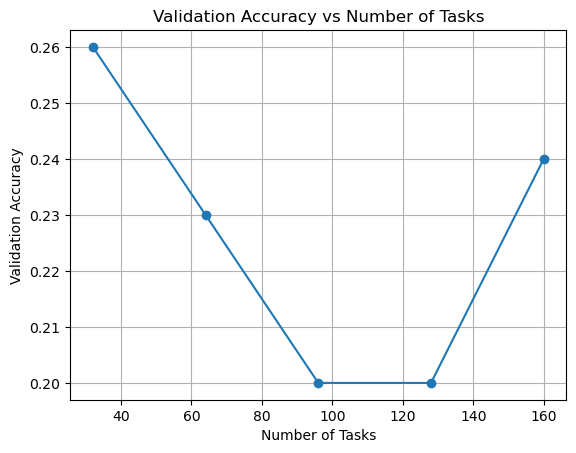

In [102]:
solver = 'base' # base, meta
meta_model, optimizer, loss_fn = model_init()

# 绘图
task_counts = []
val_accuracies = []

task_counter = 0  # 记录已经训练过的 task 总数

# init solver and dataset according to solver type
if solver == 'base':
    max_epoch = 5 # the base solver only needs 5 epochs
    Solver = BaseSolver
    train_set, val_set = torch.utils.data.random_split(
        Omniglot(train_data_path, k_shot, q_query, task_num=10), [5, 5]
    )
    (train_loader, val_loader), (train_iter, val_iter) = dataloader_init((train_set, val_set), shuffle=False)

elif solver == 'meta':
    Solver = MetaSolver
    dataset = Omniglot(train_data_path, k_shot, q_query)
    train_split = int(0.8 * len(dataset))
    val_split = len(dataset) - train_split
    train_set, val_set = torch.utils.data.random_split(
        dataset, [train_split, val_split]
    )
    (train_loader, val_loader), (train_iter, val_iter) = dataloader_init((train_set, val_set))
else:
    raise NotImplementedError


# main training loop
for epoch in range(max_epoch):
    print("Epoch %d" % (epoch + 1))
    train_meta_loss = []
    train_acc = []
    # The "step" here is a meta-gradinet update step
    for step in tqdm(range(max(1, len(train_loader) // meta_batch_size))):
        x, train_iter = get_meta_batch(
            meta_batch_size, k_shot, q_query, train_loader, train_iter
        )
        meta_loss, acc = Solver(
            meta_model,
            optimizer,
            x,
            n_way,
            k_shot,
            q_query,
            loss_fn,
            inner_train_step=train_inner_train_step
        )
        train_meta_loss.append(meta_loss.item())
        train_acc.append(acc)
        task_counter += meta_batch_size # add
    print("  Loss    : ", "%.3f" % (np.mean(train_meta_loss)), end="\t")
    print("  Accuracy: ", "%.3f %%" % (np.mean(train_acc) * 100))

    # See the validation accuracy after each epoch.
    # Early stopping is welcomed to implement.
    val_acc = []
    for eval_step in tqdm(range(max(1, len(val_loader) // (eval_batches)))):
        x, val_iter = get_meta_batch(
            eval_batches, k_shot, q_query, val_loader, val_iter
        )
        # We update three inner steps when testing.
        _, acc = Solver(
            meta_model,
            optimizer,
            x,
            n_way,
            k_shot,
            q_query,
            loss_fn,
            inner_train_step=val_inner_train_step,
            train=False,
        )
        val_acc.append(acc)
    print("  Validation accuracy: ", "%.3f %%" % (np.mean(val_acc) * 100))

    # 任务数与验证准确率
    val_accuracies.append(np.mean(val_acc))
    task_counts.append(task_counter)

plt.plot(task_counts, val_accuracies, marker='o')
plt.xlabel("Number of Tasks")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Number of Tasks")
plt.grid(True)
plt.show()

### Testing the result

Since the testing data is sampled in advance, you should not change the code in `OmnigloTest` dataset, otherwise your score may not be correct.

However, fell free to chagne the variable `inner_train_step` to set the training steps on the query set images.

由于测试数据是预先采样的，所以不应该更改OmnigloTest数据集中的代码，否则您的分数可能不正确。但是，可以随意更改变量inner_train_step来设置查询集图像上的训练步骤。

In [96]:
import os

# test dataset
class OmniglotTest(Dataset):
    def __init__(self, test_dir):
        self.test_dir = test_dir
        self.n = 5

        self.transform = transforms.Compose([transforms.ToTensor()])

    def __getitem__(self, idx):
        support_files = [
            os.path.join(self.test_dir, "support", f"{idx:>04}", f"image_{i}.png")
            for i in range(self.n)
        ]
        query_files = [
            os.path.join(self.test_dir, "query", f"{idx:>04}", f"image_{i}.png")
            for i in range(self.n)
        ]

        support_imgs = torch.stack(
            [self.transform(Image.open(e)) for e in support_files]
        )
        query_imgs = torch.stack([self.transform(Image.open(e)) for e in query_files])

        return support_imgs, query_imgs

    def __len__(self):
        return len(os.listdir(os.path.join(self.test_dir, "support")))

In [97]:
test_inner_train_step = 15 # you can change this base:10

test_batches = 15
test_dataset = OmniglotTest("Omniglot-test")
test_loader = DataLoader(test_dataset, batch_size=test_batches, shuffle=False)

output = []
for _, batch in enumerate(tqdm(test_loader)):
    support_set, query_set = batch
    x = torch.cat([support_set, query_set], dim=1)
    x = x.to(device)

    labels = Solver(
        meta_model,
        optimizer,
        x,
        n_way,
        k_shot,
        q_query,
        loss_fn,
        inner_train_step=test_inner_train_step,
        train=False,
        return_labels=True,
    )

    output.extend(labels)

100%|██████████| 43/43 [00:46<00:00,  1.09s/it]


In [98]:
if solver == "meta":
    output_csv_path = "meta_output.csv"
elif solver == "base":
    output_csv_path = "base_output.csv"

# write to csv
with open(output_csv_path, "w") as f:
    f.write(f"id,class\n")
    for i, label in enumerate(output):
        f.write(f"{i},{label}\n")

In [99]:
meta_output_path = "meta_output.csv"
base_output_path = "base_output.csv"

true_labels_path = "true_labels.csv"

true_labels = np.array(pd.read_csv(true_labels_path)['class'])

meta_output = np.array(pd.read_csv(meta_output_path)['class'])
base_output = np.array(pd.read_csv(base_output_path)['class'])

meta_accuracy = np.mean(np.array(meta_output) == np.array(true_labels))
base_accuracy = np.mean(np.array(base_output) == np.array(true_labels))

print(f"\nMeta Test Accuracy: {meta_accuracy * 100:.2f}%")
print(f"\nBase Test Accuracy: {base_accuracy * 100:.2f}%")


Meta Test Accuracy: 77.25%

Base Test Accuracy: 61.78%


## **Reference**
1. Chelsea Finn, Pieter Abbeel, & Sergey Levine. (2017). [Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks.](https://arxiv.org/abs/1909.09157)
1. Aniruddh Raghu, Maithra Raghu, Samy Bengio, & Oriol Vinyals. (2020). [Rapid Learning or Feature Reuse? Towards Understanding the Effectiveness of MAML.](https://arxiv.org/abs/1909.09157)